# Определение перспективного тарифа для телеком компании

### Оглавление

   **[Описание проекта](#1)**

1. **[Описание данных](#2)**
    * [Описание тарифов](#3)
    * [Таблицы с данными](#4)
        * [Сообщения]
        * [Интернет]
        * [Телефонные звонки]
        * [Информация о пользователях]
    
    
2. **[Предобработка данных](#5)**
    * [Изменение типов данных](#6)
    * [Поиск и устранение ошибок в данных](#7)
         * [Телефонные звонки]
         * [Сообщения]
         * [Интернет]
   
    
3. **[Анализ данных](#8)**
    * [По всей совокупности](#9)
    * [Группировка данных](#10)
    * [По выборкам](#11)
        * [Мобильный интернет](#12)
        * [Продолжительность телефонных разговоров](#13)
        * [Количество телефонных разговоров](#14)
        * [Количество отправленных СМС](#15)
        * [Общая прибыль](#16)
4. **[Проверка гипотез](#17)**
    * [Гипотеза №1]
    * [Гипотеза №2]
    

5. **[Вывод](#18)**

### <a id="1">Описание проекта</a>

Заказчик - компания «Мегалайн» — федеральный оператор сотовой связи. Компания предлагает клиентам два тарифных плана: **«Смарт»** и **«Ультра»**. Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Необходимо проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
Наша цель - провести детальный анализ тарифов по имеющимся показателям и ответить на два главных вопроса: различается ли средняя выручка для пользователей разных тарифов, и различается ли средняя выручка для пользователей из Москвы и пользователей из других регионов.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats as st

In [2]:
# отключим ограничение количества отображаемых столбцов таблицы
pd.options.display.max_columns = None

In [3]:
calls = pd.read_csv('C:\\Users\\503so\\OneDrive\\Desktop\\praktikum-to-git\\04_calls.csv')
internet = pd.read_csv('C:\\Users\\503so\\OneDrive\\Desktop\\praktikum-to-git\\04_internet.csv')
messages = pd.read_csv('C:\\Users\\503so\\OneDrive\\Desktop\\praktikum-to-git\\04_messages.csv')
tariffs = pd.read_csv('C:\\Users\\503so\\OneDrive\\Desktop\\praktikum-to-git\\04_tariffs.csv')
users = pd.read_csv('C:\\Users\\503so\\OneDrive\\Desktop\\praktikum-to-git\\04_users.csv')

### <a id="2">1. Описание данных</a>

### <a id="3">1.1. Описание тарифов</a>

Тариф «*Смарт*»

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:

    минута разговора: 3 рубля
    сообщение: 3 рубля
    1 Гб интернет-трафика: 200 рублей

Тариф «*Ультра*»

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:

    минута разговора: 1 рубль
    сообщение: 1 рубль
    1 Гб интернет-трафика: 150 рублей

<font color ='grey'>Обратить внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

In [4]:
# заменим для простоты названия столбца 'tariff_name' на 'tariff'
tariffs['tariff'] = tariffs['tariff_name']
tariffs = tariffs.drop('tariff_name', axis=1)
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Столбцы таблицы tariffs (информация о тарифах):

    tariff — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [5]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff                 2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### <a id="4">1.2. Таблицы с данными</a>

#### Сообщения

In [6]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Столбцы таблицы messages (информация о сообщениях):

    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

In [7]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


#### Интернет

In [8]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Столбцы таблицы internet (информация об интернет-сессиях):

    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [10]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


#### Телефонные звонки

In [11]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Столбцы таблицы calls (информация о звонках):

    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок

In [12]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [13]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


#### Информация о пользователях

In [14]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Столбцы таблицы users (информация о пользователях):

    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tariff — название тарифного плана

In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [16]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


### <a id="5">2. Подготовка данных</a>

### <a id="6">2.1. Изменение типов данных</a>

Во всех наших таблицах столбцы с датой включают в себя данные типа *object*, приведем их к формату даты datetime и добавим к таблицам новый столбец, возвращающий месяц из даты (для категоризации данных по месяцам, поскольку календарный месяц - расчетный период для начисления абонентской платы и обновления лимитов по тарифу).

In [17]:
# сохраним в переменной f формат даты
f='%Y.%m.%d'

In [18]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format=f)
users['churn_date'] = pd.to_datetime(users['churn_date'], format=f)
users['reg_month'] = users['reg_date'].dt.month

In [19]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format=f)
internet['month'] = internet['session_date'].dt.month

In [20]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format=f)
calls['month'] = calls['call_date'].dt.month

In [21]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format=f)
messages['month'] = messages['message_date'].dt.month

### <a id="7"> 2.2. Поиск и устранение ошибок в данных</a>

#### Звонки

In [22]:
calls.describe()

,duration,user_id,month
count,202607.000000,202607.000000,202607.000000
mean,6.755887,1253.940619,8.574067
std,5.843365,144.722751,2.787093
min,0.000000,1000.000000,1.000000
25%,1.300000,1126.000000,7.000000
50%,6.000000,1260.000000,9.000000
75%,10.700000,1379.000000,11.000000
max,38.000000,1499.000000,12.000000


Мы можем заметить, что минимальное значение длительности составляет 0.0 минут. Поскольку мы знаем, что длительность тарифицируемых звонков окуругляется в большую сторону с точностью до минуты (при длительности звонка в 1 секунду засчитывается 1 минута), в данном случае имеем дело с несостоявшимися исходящими звонками (абонент-реципиент не ответил на звонок, либо абонент-пользователь сам отменил вызов).

In [23]:
# выведем на экран количество записей, соответствующих нулевой 
# длительности разговора
calls[calls['duration'] == 0.0]['duration'].value_counts()

0.0    39613
Name: duration, dtype: int64

Поскольку звонки с длительностью в 0.0 минут не тарифицируются, можем удалить записи о них из нашего датасета.

In [24]:
calls = calls.query("duration != 0")

In [25]:
calls.describe()

,duration,user_id,month
count,162994.000000,162994.000000,162994.000000
mean,8.397794,1254.149877,8.572960
std,5.353022,144.751050,2.787315
min,0.010000,1000.000000,1.000000
25%,4.170000,1126.000000,7.000000
50%,7.740000,1261.000000,9.000000
75%,11.850000,1379.000000,11.000000
max,38.000000,1499.000000,12.000000


Итак, удалив из таблицы строки с нулевой длительностью, мы избавились от 39613 записей. При этом среднее значение увеличилось с 6.76 минут до 8.4 минут. Медиана отклонилась вправо с 6.0 минут до 7.74 минут. Минимальное значение при этом стало равно 0.01 минуте. Этого вряд ли достаточно для того, чтобы передать какую-то информацию, но достаточно для тарификации. Поскольку оператор округляет любой состоявшийся разговор до минуты в большую сторону. Произведем округление согласно плану тарификации:

In [26]:
calls['duration'] = calls['duration'].apply(lambda x: math.ceil(x))

In [27]:
calls.describe()

,duration,user_id,month
count,162994.000000,162994.000000,162994.000000
mean,8.897880,1254.149877,8.572960
std,5.353761,144.751050,2.787315
min,1.000000,1000.000000,1.000000
25%,5.000000,1126.000000,7.000000
50%,8.000000,1261.000000,9.000000
75%,12.000000,1379.000000,11.000000
max,38.000000,1499.000000,12.000000


Таким образом мы получили датасет с измененными значениями длительности разговора: мы избавились от нетарифицируемых нулевых значений и округлили все ненулевые значения в большую сторону до целого.

Минимальное значение составляет 1 минуту, максимальное - 38 минут, среднее значение - 8.9 минуты, медиана - 8 минут.

#### Сообщения

In [28]:
# выведем информацию о датафрейме
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


В нашей таблице строка соответствует одному отправленному сообщению. Построим сводную таблицу, которая будет выводить в строках пользователей, а в столбце - количество сообщений этих пользователей за год.

In [29]:
messages_by_user = messages.pivot_table(
    index='user_id', values='id', aggfunc='count').reset_index()
messages_by_user.columns = ['user_id', 'messages_count']

messages_by_user.sort_values(by='messages_count')

,user_id,messages_count
119,1141,1
133,1159,2
65,1074,3
233,1279,5
97,1111,6
...,...,...
300,1356,1224
323,1385,1380
191,1231,1384
78,1089,1408


Как мы знаем, наша выборка содержит данные о 500 пользователях мобильного оператора, однако в сводной таблице выше, содержащей общее количество отправленных сообщений каждым пользователем за год, всего 426 строк. То есть не хватает 74 строк.
Отсортировав данные по возрастанию, видим, что минимальное количество сообщений равно 1. Таким образом, очевидно, что 74 пользователя из 500 (около 15% всех пользователей) за все время наблюдений не отправили ни одного сообщения, а потому не попали в итоговую статистику.

In [30]:
messages_by_user['messages_count'].describe()

count     426.000000
mean      288.816901
std       267.607552
min         1.000000
25%        85.750000
50%       215.500000
75%       414.000000
max      1463.000000
Name: messages_count, dtype: float64

Добавим в таблицу строки с *user_id* пользователей, которых нет в таблице **messages_by_user**, после чего заполним соответсвующие им количества сообщений значением "0".

In [31]:
messages_by_user = messages_by_user.merge(users, on='user_id', how='right')
messages_by_user = pd.DataFrame([messages_by_user.user_id, messages_by_user.messages_count]).transpose()
messages_by_user['messages_count'] = messages_by_user['messages_count'].fillna(0)

messages_by_user

,user_id,messages_count
0,1000.0,496.0
1,1002.0,70.0
2,1003.0,380.0
3,1004.0,1192.0
4,1005.0,552.0
...,...,...
495,1462.0,0.0
496,1466.0,0.0
497,1469.0,0.0
498,1479.0,0.0


In [32]:
messages_by_user['messages_count'].describe()

count     500.000000
mean      246.072000
std       267.456765
min         0.000000
25%        42.000000
50%       164.500000
75%       370.000000
max      1463.000000
Name: messages_count, dtype: float64

Как можно заметить, добавление в таблицу пользователей, отправивших 0 сообщений за год, повлияло на среднее значение и медиану: среднее значение снизилось с 288 сообщений до 246, а медиана - с 215.5 до 164.5 сообщений.

Построим график распределения значений количества отправленных пользователями сообщений за год.

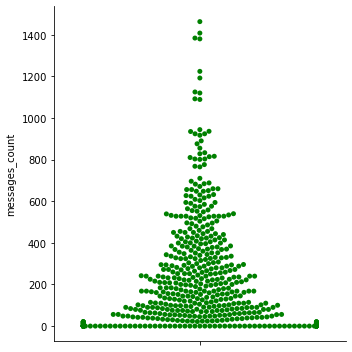

In [33]:
sns.catplot(y='messages_count',
            kind='swarm',
            data=messages_by_user,
            color='green')
plt.show()

На основании анализа отправленных пользователями сообщений за год можно сделать вывод, что около 15% пользователей вообще не пользуются услугой отправки СМС, всего 10 человек (2%) за год отправили более 1000 сообщений и 75% пользователей отправили за год не более 370 СМС.

Также на графике можем наблюдать постепенное уменьшение количества пользователей при постепенном увеличинии количества отправленных сообщений, и только в районе 550 СМС/год количество пользователей локально возрастает. Это может быть обусловлено тем, что некоторые пользователи тарифа "Смарт" используют свой пакет СМС по-максимуму, не превышая при этом лимита (550 / 12 ≈ 46 сообщений в месяц).

Вышеописанный пропуск в данных имеет значение при анализе именно картины с отправкой сообщений, и не играет большой роли при расчете прибыли, полученной компанией-оператором. Неотправленные СМС, как и звонки с длительностью в 0 минут, не приносят дохода, поэтому не будем возвращать по параметру "количество сообщений" те значения, которые мы удалили для "совершенных вызовов".

#### Интернет

In [34]:
internet.describe()

,Unnamed: 0,mb_used,user_id,month
count,149396.000000,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842,8.563315
std,43127.054745,278.300951,144.050823,2.788717
min,0.000000,0.000000,1000.000000,1.000000
25%,37348.750000,138.187500,1130.000000,7.000000
50%,74697.500000,348.015000,1251.000000,9.000000
75%,112046.250000,559.552500,1380.000000,11.000000
max,149395.000000,1724.830000,1499.000000,12.000000


Для интернет-сессий минимальное значение также равно 0. Выясним, сколько в таблице содержится нулевых записей.

In [35]:
internet[internet['mb_used'] == 0]['mb_used'].value_counts()

0.0    19598
Name: mb_used, dtype: int64

19598 строк, не несущие в себе полезной информации. Скорее всего они возникли при округлении значеений расхода трафика мобильного интернета, и символизируют расход трафика, исчислимый в единицах килобайт, или даже сотен и десятков байт. Учитывая размеры нетарифицируемых лифитов, можем считать данные записи несущественными. 

(В случае, если бы была важна более высокая точность, можно было бы заменить нулевые значения средним между нулевым значением и порогом считывания: если минимальная единица измерения - 0.1 Мб, то нулевые значения можно было бы заполнить значением 0.05 Мб).

In [36]:
# присвоим таблице значение ее среза для ненулевых значений параметра 'mb_used'
internet = internet.query("mb_used != 0")

Мы знаем, что оператор округляет объем трафика каждой интернет-сессии до целого значения.

In [37]:
internet['mb_used'] = internet['mb_used'].apply(math.ceil)

In [38]:
internet.describe()

,Unnamed: 0,mb_used,user_id,month
count,129798.000000,129798.000000,129798.000000,129798.000000
mean,74978.644879,426.581758,1253.046318,8.558013
std,43047.137838,255.596114,143.782672,2.787862
min,0.000000,1.000000,1000.000000,1.000000
25%,37675.250000,228.000000,1132.000000,7.000000
50%,75253.000000,401.000000,1252.000000,9.000000
75%,112247.750000,593.000000,1380.000000,11.000000
max,149395.000000,1725.000000,1499.000000,12.000000


Таким образом мы уменьшили количество записей 19598 (или на 13%).Среднее значение при этом увеличилось с 370 до 426 Мб, а медиана - с 348 до 401 Мб.

### <a id="8">3. Анализ данных</a>

### <a id="9">3.1. По всей совокупности</a>

#### Пользователи

Узнаем, сколько пользователей относилось к каждому тарифу на момент сбора данных, а также выясним, сколько пользователей в абсолютном и относительном значениях отказались от своих тарифов.

In [39]:
# если в столбце 'churn_date' отсутствует значение, значит на момент сбора данных пользователь
# оставался абонентом указанного тарифа
users[users['churn_date'].isna()]['tariff'].value_counts()

smart    328
ultra    134
Name: tariff, dtype: int64

In [40]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [41]:
print('От тарифа "smart" отказалось', 351 - 328, 
      'пользователя. Отказы составляют {:.2%}'.format((351 - 328) / 351))

print('От тарифа "ultra" отказалось', 149 - 134,
      'пользователей. Отказы составляют {:.2%}'.format((149 - 134) / 149))

От тарифа "smart" отказалось 23 пользователя. Отказы составляют 6.55%
От тарифа "ultra" отказалось 15 пользователей. Отказы составляют 10.07%


#### Телефонные звонки

Для начала создадим сводную таблицу, в которой сгруппируем данные по уникальным пользователям и по месяцам, а в значениях отразим суммарную длительность исходящих телефонных разговоров по месяцам и их количество.

In [42]:
calls_grouped = calls.groupby(['user_id', 'month']).agg(
    {'duration':'sum', 'id':'count'}).reset_index()

In [43]:
calls_grouped.columns = ('user_id', 'month', 'calls_duration', 'calls_count')
calls_grouped

,user_id,month,calls_duration,calls_count
0,1000,5,159,17
1,1000,6,172,28
2,1000,7,340,41
3,1000,8,408,42
4,1000,9,466,46
...,...,...,...,...
3163,1498,10,247,30
3164,1499,9,70,8
3165,1499,10,449,44
3166,1499,11,612,62


In [44]:
calls_grouped.describe()

,user_id,month,calls_duration,calls_count
count,3168.000000,3168.000000,3168.000000,3168.000000
mean,1251.477588,8.317551,457.797033,51.450126
std,144.574946,2.907181,237.423514,26.439188
min,1000.000000,1.000000,1.000000,1.000000
25%,1126.000000,6.000000,290.750000,33.000000
50%,1254.000000,9.000000,447.500000,50.000000
75%,1379.000000,11.000000,592.250000,67.000000
max,1499.000000,12.000000,1673.000000,190.000000


Рассчитаем коэффициент корреляции между показателями "*общая длительность разговора*" и "*количество телефонных разговоров*".

In [45]:
calls_grouped['calls_duration'].corr(calls_grouped['calls_count'])

0.9873555363996793

Полученный коэффициент составляет почти 0.99. Этот показатель близок к максимальному возможному значению (1). Т.е. указанные параметры находятся в сильной положительной корреляции. 
Действительно, уже по тому факту, что среднее значения и медиана очень близки друг к другу (458 минут и 448 минут соответственно), можно говорить о высокой степени симметричности распределения и о сильной взаимозависимости рассматриваемых величин.

Построим гистограммы распределения значений для двух изучаемых характеристик.

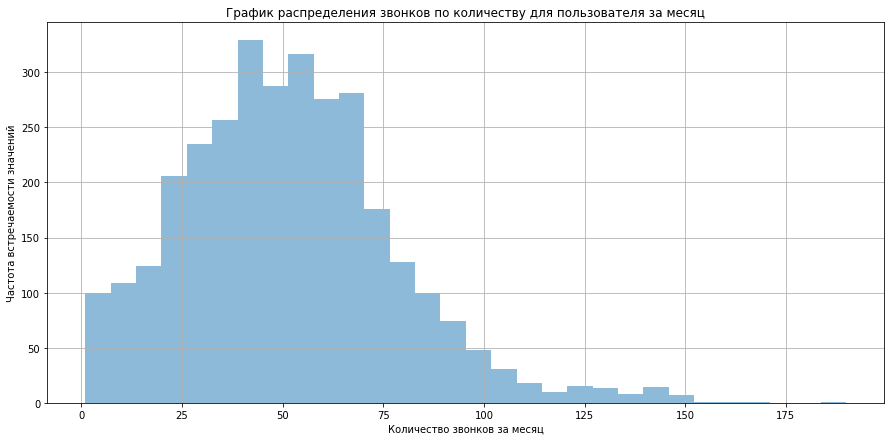

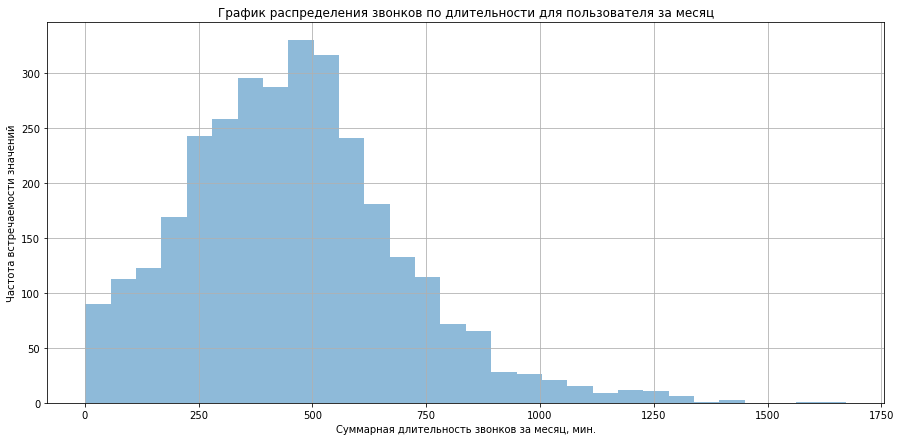

In [46]:
ax = calls_grouped['calls_count'].plot(
    kind='hist', bins=30, alpha=0.5, figsize=(15,7), grid=True, label='Количество звонков')
ax.set_xlabel('Количество звонков за месяц')
ax.set_ylabel('Частота встречаемости значений')
ax.set_title('График распределения звонков по количеству для пользователя за месяц')

plt.show()

ax = calls_grouped['calls_duration'].plot(
    kind='hist', bins=30, alpha=0.5, figsize=(15,7), 
    grid=True, label='Суммарная длительность звонков по месяцам')
ax.set_xlabel('Суммарная длительность звонков за месяц, мин.')
ax.set_ylabel('Частота встречаемости значений')
ax.set_title('График распределения звонков по длительности для пользователя за месяц')

plt.show()

Действительно, в подтверждение вышеописанного вывода, графики имеют в значительной степени сходный внешний вид.

В среднем пользователи говорят около 460 минут в месяц и совершают около 50 звонков. Т.е. приблизительно чуть больше 15 минут в день, распределенные между одним - двумя звонками. При этом, исходя из высокого коэффициента корреляции, можно говорить о том, что в выборках мало записей с нестандартным соотношением длительности и количества звонков (очень много очень коротких разговоров, или очень мало длинных), единичные разговоры разных пользователей похожи друг на друга (не по смыслу, но по механизму).

#### Сообщения

Создадим сводную таблицу по сообщениям. В качестве категорий объединения данных используем уникальных пользователей и месяцы, в качестве значений - количество сообщений.

In [47]:
messages_grouped = messages.groupby(['user_id', 'month']).agg(
    {'id':'count'}).reset_index()
messages_grouped.columns = ('user_id', 'month', 'messages_count')

In [48]:
messages_grouped

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Построим гистограмму распределения для сообщений.

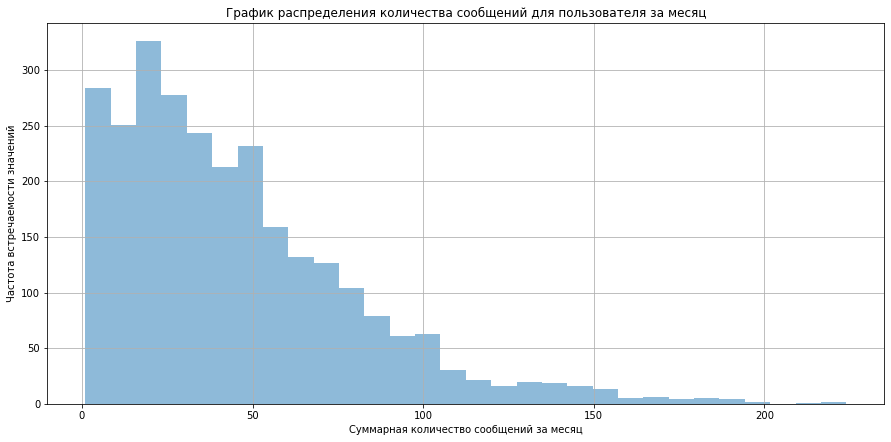

In [49]:
ax = messages_grouped['messages_count'].plot(
    kind='hist', bins=30, alpha=0.5, figsize=(15,7), 
    grid=True, label='Суммарное количество сообщений по месяцам')
ax.set_xlabel('Суммарная количество сообщений за месяц')
ax.set_ylabel('Частота встречаемости значений')
ax.set_title('График распределения количества сообщений для пользователя за месяц')
plt.show()

#### Интернет

In [50]:
internet_grouped = internet.groupby(['user_id', 'month']).agg(
    {'mb_used':'sum'}).reset_index()
internet_grouped

,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
...,...,...,...
3196,1498,10,20604
3197,1499,9,1848
3198,1499,10,17809
3199,1499,11,17984


### <a id="10">3.2. Группировка данных</a>

Создадим таблицу **table**, в которую объединим сгруппированные по пользователям и месяцам данные из таблиц **calls_grouped, messages_grouped, internet_grouped**. После чего добавим необходимые столбцы из таблиц **users и tariffs**.

In [51]:
table = calls_grouped.merge(messages_grouped, on = ['user_id', 'month'], how='outer')

In [52]:
table = table.merge(internet_grouped, on = ['user_id', 'month'], how='outer')

In [53]:
table = table.merge(users, on='user_id', how='outer')
lst = ['first_name', 'last_name', 'reg_date']
for col in lst:
    table = table.drop(col, axis=1)
    
table = table.merge(tariffs, on='tariff', how='left')

Рассчитаем значение *delta* (разницу) для звонков, СМС и интернета, которая сообщит о наличии и степени превышения лимитов, доступных по тарифу. Добавим новые столбцы в таблицу.

In [54]:
table['delta_calls'] = - table['minutes_included'] + table['calls_duration']
table['delta_messages'] = - table['messages_included'] + table['messages_count']
table['delta_internet'] =  - table['mb_per_month_included'] + table['mb_used']

In [55]:
# создадим список, содержащий имена столбцов с прибылью от реализации услуг
profit_list = ['calls_profit', 'messages_profit', 'internet_profit']

#добавим столбцы, содерожащие прибыль от реализации различных услуг
#(интернет, СМС и минуты разговора сверх лимита), для этого перемножим
# значение delta на стоимость одной единицы предоставляемой услуги

table['calls_profit'] = table[table[
    'delta_calls'] > 0]['delta_calls'] * table['rub_per_minute']

table['messages_profit'] = table[table[
    'delta_messages'] > 0]['delta_messages'] * table['rub_per_message']

table['internet_profit'] = (table[table[
    'delta_internet'] > 0]['delta_internet'] / 1024 # переведем мегабайты в гигабайты
                           ).apply(lambda x: math.ceil(x)) * table['rub_per_gb']

In [56]:
# заполним пропуски в столбцах из списка profit_list нулевыми значениями
table[profit_list] = table[profit_list].fillna(0)

#вычислим общую прибыль как сумму абонентской платы и прибыли от услуг связи сверх лимита
table['total_profit'] = (table['calls_profit'] 
                         + table['messages_profit'] 
                         + table['internet_profit'] 
                         + table['rub_monthly_fee'])

In [57]:
# выведем полученную таблицу на экран
table

,user_id,month,calls_duration,calls_count,messages_count,mb_used,age,churn_date,city,tariff,reg_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,delta_calls,delta_messages,delta_internet,calls_profit,messages_profit,internet_profit,total_profit
0,1000,5.0,159.0,17.0,22.0,2256.0,52,NaT,Краснодар,ultra,5,1000,30720,3000,1950,150,1,1,-2841.0,-978.0,-28464.0,0.0,0.0,0.0,1950.0
1,1000,6.0,172.0,28.0,60.0,23257.0,52,NaT,Краснодар,ultra,5,1000,30720,3000,1950,150,1,1,-2828.0,-940.0,-7463.0,0.0,0.0,0.0,1950.0
2,1000,7.0,340.0,41.0,75.0,14016.0,52,NaT,Краснодар,ultra,5,1000,30720,3000,1950,150,1,1,-2660.0,-925.0,-16704.0,0.0,0.0,0.0,1950.0
3,1000,8.0,408.0,42.0,81.0,14070.0,52,NaT,Краснодар,ultra,5,1000,30720,3000,1950,150,1,1,-2592.0,-919.0,-16650.0,0.0,0.0,0.0,1950.0
4,1000,9.0,466.0,46.0,57.0,14581.0,52,NaT,Краснодар,ultra,5,1000,30720,3000,1950,150,1,1,-2534.0,-943.0,-16139.0,0.0,0.0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,19588.0,35,NaT,Санкт-Петербург,smart,8,50,15360,500,550,200,3,3,NaN,-29.0,4228.0,0.0,0.0,1000.0,1550.0
3212,1489,11.0,NaN,NaN,20.0,17516.0,35,NaT,Санкт-Петербург,smart,8,50,15360,500,550,200,3,3,NaN,-30.0,2156.0,0.0,0.0,600.0,1150.0
3213,1489,12.0,NaN,NaN,35.0,17341.0,35,NaT,Санкт-Петербург,smart,8,50,15360,500,550,200,3,3,NaN,-15.0,1981.0,0.0,0.0,400.0,950.0
3214,1128,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,ultra,12,1000,30720,3000,1950,150,1,1,NaN,NaN,NaN,0.0,0.0,0.0,1950.0


Выясним, сколько всего прибыли компании принесли пользователи тарифов "*Смарт*" и "*Ультра*".

In [58]:
small_profit_pivot = table.groupby('tariff').agg({'total_profit' : sum}).reset_index()
small_profit_pivot

,tariff,total_profit
0,smart,2886301.0
1,ultra,2041950.0


И построим круговую диаграмму.

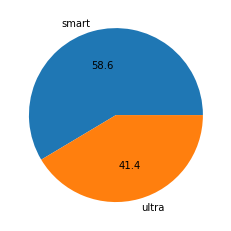

In [59]:
fig1, ax1 = plt.subplots()
ax1.pie(small_profit_pivot['total_profit'], labels=small_profit_pivot['tariff'], autopct='%.1f')
plt.show()

На основании имеющихся у нас записей данных, можем заключить, что тариф "*Смарт*" принес больше прибыли компании-оператору, чем тариф "*Ультра*". Однако это может в большей степени зависеть от количества пользователей тарифа, чем от его прибыльности. Для определения более прибыльного тарифа в последующих разделах рассчитаем среднюю величину прибыли по каждому из тарифов, а также выясним, какова вероятность равенства этих средних.

### <a id="11">3.3. По выборкам</a>

### <a id="12">3.3.1. Анализ использования мобильного интернета</a>

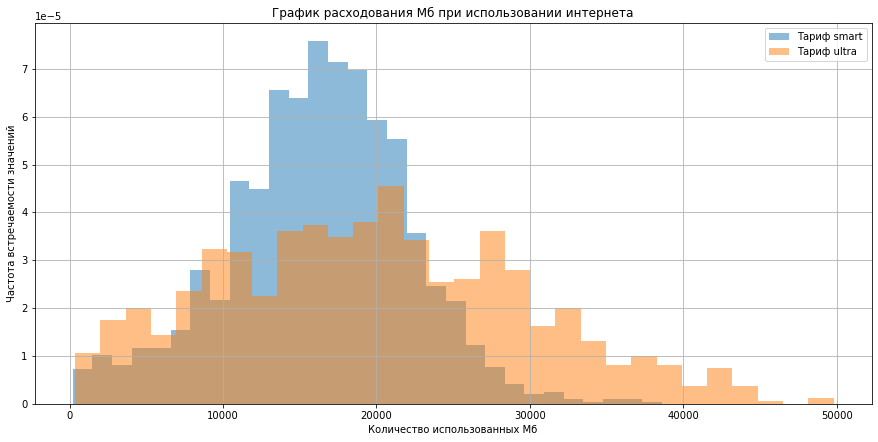

In [60]:
ax = table[table['tariff'] == 'smart']['mb_used'].plot(
    kind='hist', bins=30, alpha=0.5, figsize=(15,7), grid=True, label='Тариф smart', density=True )

ax = table[table['tariff'] == 'ultra']['mb_used'].plot(
    kind='hist', bins=30, alpha=0.5, figsize=(15,7), grid=True, label='Тариф ultra', density=True )

ax.set_xlabel('Количество использованных Мб')
ax.set_ylabel('Частота встречаемости значений')
ax.set_title('График расходования Мб при использовании интернета')

ax.legend()
plt.show()

Как видно из графика, пользователи тарифа "*Смарт*" расходуют примерно до 25 - 27 Гб мобильного интернета, а пользователи тарифа "*Ультра*" - до 45 Гб. При этом для тарифа "*Смарт*" такие показатели являются более сильным превышением лимита, чем для тарифа "*Ультра*" при том, что и плата за единицу услуг сверх лимита для тарифа "*Смарт*" отличается в большую сторону.

Получим таблицу с метриками локации данных:

In [61]:
mb_used_info = table.groupby('tariff')['mb_used'].describe().join(
    table.groupby('tariff')['mb_used'].var()).reset_index().rename(
    columns={'mb_used': 'var'})

mb_used_info

,tariff,count,mean,std,min,25%,50%,75%,max,var
0,smart,2227.0,16243.763359,5860.041941,202.0,12677.00,16533.0,20068.00,38610.0,3.434009e+07
1,ultra,974.0,19706.979466,9937.127298,366.0,12073.75,19427.5,26936.25,49789.0,9.874650e+07


Среднее знвачение и медиана для обеих выборок очень близки друк к другу, это может говорить о том, что данные распределены равномерно. Однако для тарифа "*Смарт*" среднее значение немного больше медианы, а для тарифа "*Ультра*" медиана больше среднего значения. Т.е. распределение значений тарифа "*Смарт*" незначительно скошено вправо, а "*Ультра*" - влево.

### <a id="13">3.3.2. Анализ количества звонков</a>

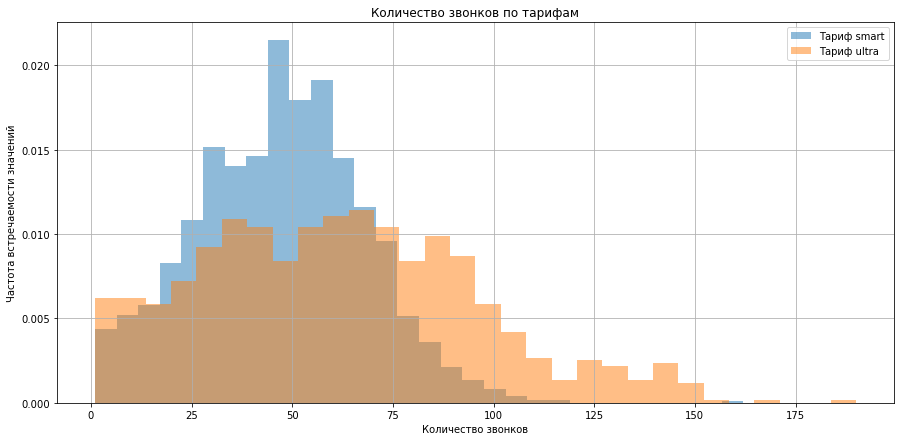

In [62]:
ax = table[table['tariff'] == 'smart']['calls_count'].plot(
    kind='hist', bins=30, alpha=0.5, figsize=(15,7), grid=True, label='Тариф smart', density=True )

ax = table[table['tariff'] == 'ultra']['calls_count'].plot(
    kind='hist', bins=30, alpha=0.5, figsize=(15,7), grid=True, label='Тариф ultra', density=True )

ax.set_xlabel('Количество звонков')
ax.set_ylabel('Частота встречаемости значений')
ax.set_title('Количество звонков по тарифам')

ax.legend()
plt.show()

In [63]:
calls_count_info = table.groupby('tariff')['calls_count'].describe().join(
    table.groupby('tariff')['calls_count'].var()).reset_index().rename(
    columns={'calls_count': 'var'})

calls_count_info

,tariff,count,mean,std,min,25%,50%,75%,max,var
0,smart,2221.0,47.116614,20.887092,1.0,32.0,48.0,61.0,162.0,436.270629
1,ultra,947.0,61.613516,34.189197,1.0,35.0,61.0,84.0,190.0,1168.901212


### <a id="14">3.3.3. Анализ продолжительности звонков</a>

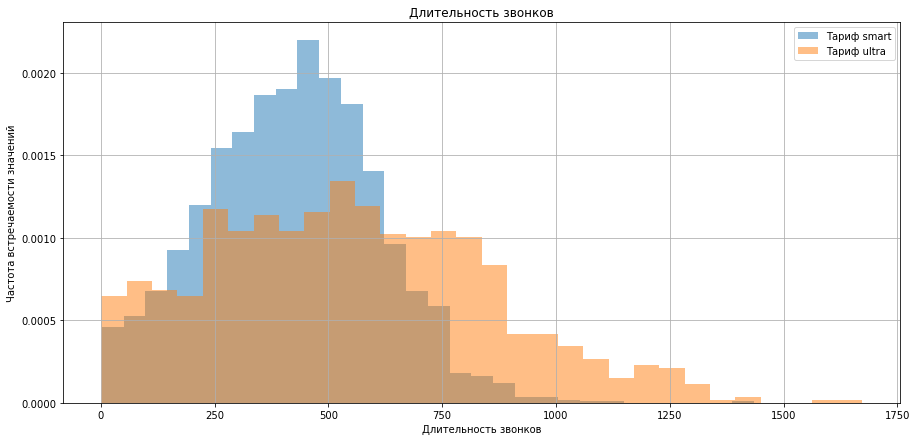

In [64]:
ax = table[table['tariff'] == 'smart']['calls_duration'].plot(
    kind='hist', bins=30, alpha=0.5, figsize=(15,7), grid=True, label='Тариф smart', density=True )

ax = table[table['tariff'] == 'ultra']['calls_duration'].plot(
    kind='hist', bins=30, alpha=0.5, figsize=(15,7), grid=True, label='Тариф ultra', density=True )

ax.set_xlabel('Длительность звонков')
ax.set_ylabel('Частота встречаемости значений')
ax.set_title('Длительность звонков')

ax.legend()
plt.show()

In [65]:
calls_duration_info = table.groupby('tariff')['calls_duration'].describe().join(
    table.groupby('tariff')['calls_duration'].var()).reset_index().rename(
    columns={'calls_duration': 'var'})

calls_duration_info

,tariff,count,mean,std,min,25%,50%,75%,max,var
0,smart,2221.0,419.440342,188.992403,2.0,285.0,423.0,546.0,1435.0,35718.128534
1,ultra,947.0,547.755016,305.513385,1.0,311.0,529.0,758.0,1673.0,93338.428291


Для количества звонков и длительности звонков графики имеют с ходный вид с графиком для интернета, следовательно, можно сделать и сходные выводы.

### <a id="15">3.3.4. Анализ количества отправленных СМС</a>

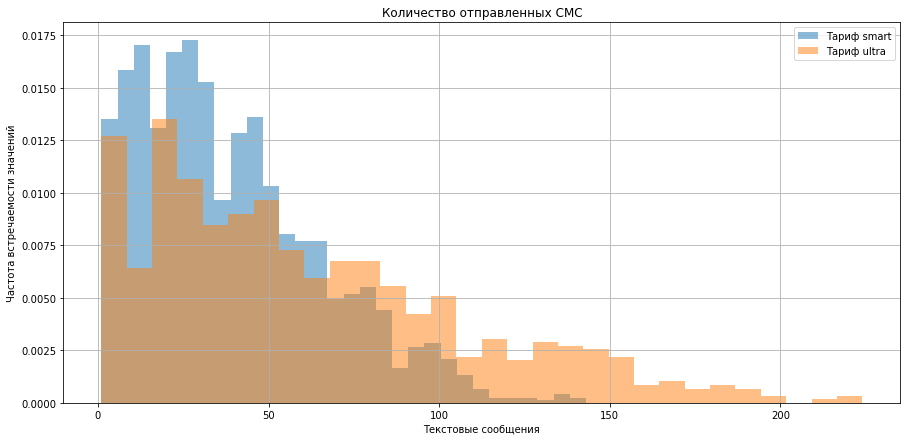

In [66]:
ax = table[table['tariff'] == 'smart']['messages_count'].plot(
    kind='hist', bins=30, alpha=0.5, figsize=(15,7), grid=True, label='Тариф smart', density=True )

ax = table[table['tariff'] == 'ultra']['messages_count'].plot(
    kind='hist', bins=30, alpha=0.5, figsize=(15,7), grid=True, label='Тариф ultra', density=True )

ax.set_xlabel('Текстовые сообщения')
ax.set_ylabel('Частота встречаемости значений')
ax.set_title('Количество отправленных СМС')

ax.legend()
plt.show()

In [67]:
messages_count_info = table.groupby('tariff')['messages_count'].describe().join(
    table.groupby('tariff')['messages_count'].var()).reset_index().rename(
    columns={'messages_count': 'var'})

messages_count_info

,tariff,count,mean,std,min,25%,50%,75%,max,var
0,smart,1922.0,38.716441,26.787949,1.0,17.0,34.0,55.0,143.0,717.594201
1,ultra,795.0,61.161006,45.931026,1.0,24.0,51.0,87.5,224.0,2109.659183


Для количества отправленных сообщений график отличается от первых трех: если они напоминали колоколообразное распределение, то график сообщений "придавлен" нулевым значением прибыли. Т. е. фактически видем здесь обратную корреляцию: на протяжении всего диапазона значений, чем больше прибыль от отправки сообщений сверх лимита, тем меньше случаев получения такой прибыли.

### <a id="16">3.3.5. Анализ суммарной прибыли</a>

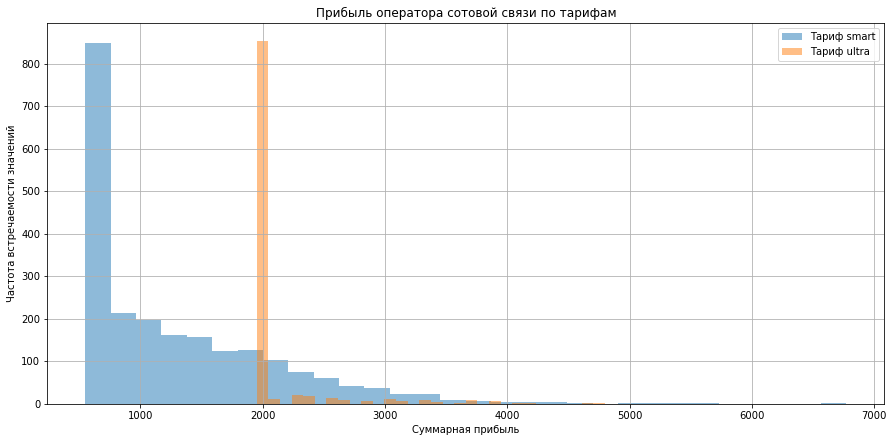

In [68]:
ax = table[table['tariff'] == 'smart']['total_profit'].plot(
    kind='hist', bins=30, alpha=0.5, figsize=(15,7), grid=True, label='Тариф smart')

ax = table[table['tariff'] == 'ultra']['total_profit'].plot(
    kind='hist', bins=30, alpha=0.5, figsize=(15,7), grid=True, label='Тариф ultra')

ax.set_xlabel('Суммарная прибыль')
ax.set_ylabel('Частота встречаемости значений')
ax.set_title('Прибыль оператора сотовой связи по тарифам')

ax.legend()
plt.show()

In [69]:
total_profit_info = table.groupby('tariff')['total_profit'].describe().join(
    table.groupby('tariff')['total_profit'].var()).reset_index().rename(
    columns={'total_profit': 'var'})

total_profit_info

,tariff,count,mean,std,min,25%,50%,75%,max,var
0,smart,2230.0,1294.305381,820.900496,550.0,550.0,1037.0,1750.0,6770.0,673877.623614
1,ultra,986.0,2070.943205,378.629673,1950.0,1950.0,1950.0,1950.0,4800.0,143360.429258


Дисперсии общей прибыли для выборок по тарифам различаются почти в 5 раз. Разброс значений для тарифа "*Ультра*" значительно ниже, чем разброс для тарифа "*Смарт*". Действительно, это видно и по графику: большая часть показателей месячной прибыли для обоих тарифов соответствует абонентской плате, однако пользователи тарифа "*Смарт*" чаще пользователей тарифа "*Ультра*" превышают лимиты.

Построим диаграмму размаха общей полученной прибыли:

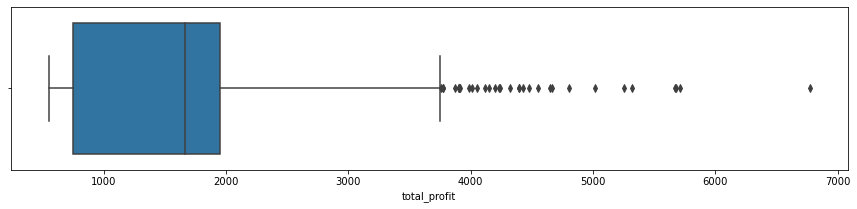

In [70]:
plt.rcParams['figure.figsize']=(15, 3)
sns.boxplot(x='total_profit', data=table, fliersize=5)
plt.show()

In [71]:
k = 1.5
profit_min = table['total_profit'].quantile(0.25) - k * (table['total_profit'].quantile(0.75) - table['total_profit'].quantile(0.25))
profit_max = table['total_profit'].quantile(0.75) + k * (table['total_profit'].quantile(0.75) - table['total_profit'].quantile(0.25))
print('Минимальная прибыль по генеральной совокупности:', profit_min)
print('Максимальная прибыль по генеральной совокупности:', profit_max)

Минимальная прибыль по генеральной совокупности: -1050.0
Максимальная прибыль по генеральной совокупности: 3750.0


Нижняя граница при расчете по правилу "*трех сигм*" приняла отрицательное значение. В таком случае в качестве нижней границы принимается минимальное значение.

In [72]:
profit_min = table['rub_monthly_fee'].min()
print('Минимальная прибыль по генеральной совокупности:', profit_min)
print('Максимальная прибыль по генеральной совокупности:', profit_max)

Минимальная прибыль по генеральной совокупности: 550
Максимальная прибыль по генеральной совокупности: 3750.0


Создадим таблицу **table_clean**, в которую поместим данные таблицы **table**, очищенные от выбросов.

In [73]:
table_clean = table[(table['total_profit'] > profit_min) & (table['total_profit'] < profit_max)]
print('Размер неочищенных данных:', table.shape)
print('Размер таблицы после очистки:', table_clean.shape)

Размер неочищенных данных: (3216, 25)
Размер таблицы после очистки: (2605, 25)


Таким образом мы избавились от 614 значений, что составляет около 20% общего количества записей. Это много, обрезка по трем сигмам достаточно грубая. Максимальное значение в 6700 р. не кажется чем-то аномальным (просто большое значение).

Выясним, из чего складывается общая прибыль для сотового оператора по таблице **table**. Для этого создадим таблицу **table_profit**, содержащую стобцы таблицы **table** с данными о прибыли от предоставления разных видов услуг.
После чего построим тепловую карту коррелляции новой таблицы, а также гистограмму распределения значений.

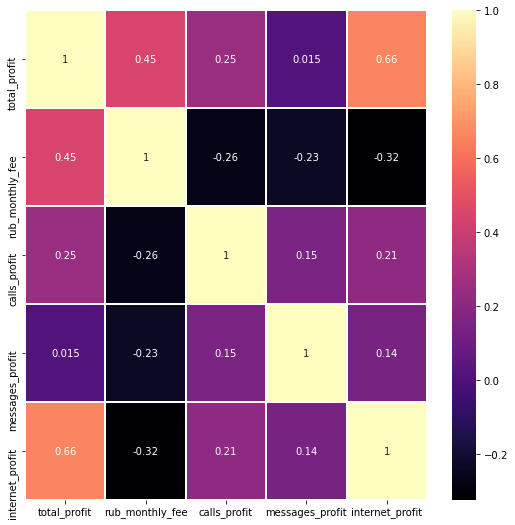

In [74]:
table_profit = table[[
    'total_profit', 'rub_monthly_fee', 'calls_profit',
    'messages_profit', 'internet_profit']]

plt.rcParams['figure.figsize']=(9,9)
sns.heatmap(table_profit.corr(), cmap='magma',linecolor='white',linewidths=1, annot=True)

#в данном случае было бы достаточно рассчитать коэффициент корреляции между общей прибылью
#и прибылью от конкретных видов услуг, за которые сотовый оператор взимает плату, но для
#наглядности построим график корреляции, это может указать на неожиданные закономерности 

Как мы видим по тепловой карте, самая сильная корреляция у общей прибыли с прибылью от платежей за использование мобильного интернета сверх лимита (**r = 0.66**). На втором месте - абонентская плата (**r = 0.45**). Коэффициент корреляции между общей прибылью и прибылью от звонков равен **0.25**, а с прибылью от отправки сообщений сверх лимита - **0.015**. 

Из этого можно сделать вывод, что модель пользования услугами мобильного оператора - комплексное явление, элементы которого взаимосвязаны.

То есть пользователь, который пишет так много СМС, что превышает лимит, тем самым заменяет сообщениями другие виды коммуникации, не превышает по ним лимиты и не переплачивает. А поскольку плата за СМС сверх лимита низкая, а "товар" штучный (в отличие от звонков, которые оцениваются по длительности, а не по количеству), влияние на общую прибыль слабое.

Теперь через цикл построим гистограмму распределения значений прибыли (общей и по категориям услуг).

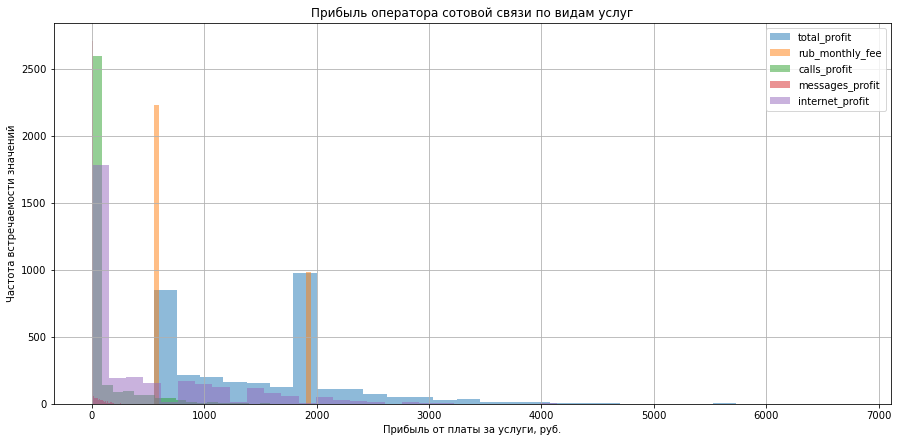

In [75]:
for cat in table_profit.columns:
    ax = table_profit[cat].plot(
        kind='hist', bins=30, alpha=0.5, figsize=(15,7), grid=True, label=cat)

ax.set_xlabel('Прибыль от платы за услуги, руб.')
ax.set_ylabel('Частота встречаемости значений')
ax.set_title('Прибыль оператора сотовой связи по видам услуг')

ax.legend()

На графике мы видим два оранжевых столбца - это обанентская плата для тарифов "*Смарт*" и "*Ультра*" . Действительно, прибыль от СМС и звонков по количеству пользователей, ее приносящих, сходит на нет уже прибюлизительно 700 руб. для звонков и 150 руб. для СМС, прибыль от использования интернета держится по частоте на ощутимом уровне до показателей в 2000 руб. и больше.
Здесь важны два фактора: **во-первых**,при превышении лимита доплата осуществляется сразу за 1 Гб (т.е. даже при незначительном превышении пользователь покупает себе дополнительный лимит довольно большого размера); **с другой стороны**, изначальный лимит является достаточно большим, и если пользователь превышает его, значит его модель использования мобильного интернета может подразумевать возможность "расточительности" и в дальнейшем.

### <a id="17">4. Проверка гипотез</a>

В данном разделе мы ответим на два вопроса:
1. Различается ли средняя прибыль, приносимая оператору пользователями разных тарифов?
2. Различается ли средняя прибыль, приносимая оператору пользователями из Москвы и из других городов?

### 4.1. Проверка гипотезы №1

<ul>
    <li>H0 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается</li>
    <li>H1 - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается</li>
</ul>

В предыдущем разделе мы определили, что дисперсии генеральных совокупностей (тариф "*Cмарт*" и тариф "*Ультра*") не равны. 
Поскольку мы имеем дело с выборками из двух генеральных совокупностей, состоящими в общей сложности из 2603 значений, можем говорить об уместности применения для оценки распределения **t-критерия Стьюдента** для независимых малых выборок из генеральных совокупностнйс разной дисперсией.

In [76]:
# поместим в отдельные списки все значения общей прибыли для обоих тарифов (выборок)
smart_list = table[table['tariff'] == 'smart']['total_profit']
ultra_list = table[table['tariff'] == 'ultra']['total_profit']

In [77]:
alpha = .01 # критический уровень статистической значимости устанавливаем в 1%,
            # у нас достаточно большие для такого значения выборки
            # //если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(    # функция ttest_ind вычисляет t-тест двух независимых выборок
    smart_list, 
    ultra_list)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.7023268870439853e-158
Отвергаем нулевую гипотезу


Таким образом, рассчитав уровень значимости **p-value** с помощью метода Стьюдента, мы отвергли нулевую гипотезу о том, что средняя прибыль по тарифам "*Смарт*" и "*Ультра*" не различается. Значит один из тарифов приносит большую прибыль, чем другой.

In [78]:
print('Средняя прибыль по тарифу "Смарт": {:.2f}'.format(smart_list.mean()))
print('Средняя прибыль по тарифу "Ультра": {:.2f}'.format(ultra_list.mean()))

Средняя прибыль по тарифу "Смарт": 1294.31
Средняя прибыль по тарифу "Ультра": 2070.94


Делаем вывод, что разница в усредненной прибыли по тарифам неслучайна, и тариф "*Ультра*" приносит больше прибыли, чем тариф "*Смарт*".

### 4.2. Проверка гипотезы №2

<ul>
    <li>H0 - Средняя выручка пользователей из Москвы и из других городов не различается</li>
    <li>H1 - Средняя выручка пользователей из Москвы и других городов различается</li>
<ul>

In [79]:
moscow_list = table[table['city'] == 'Москва']['total_profit']
other_list = table[table['city'] != 'Москва']['total_profit']

In [80]:
alpha = .01 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    moscow_list, 
    other_list)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5277299573181309
Не получилось отвергнуть нулевую гипотезу


Наша нулевая гипотеза в данном случае имеет вероятность истинности 54%. Таким образом, можно говорить о том, что у нас не получилось ее отвергнуть, и прибыль, которую сотовому оператору приносят пользователи из Москвы действительно не отличается от прибыли, приносимой пользователями из других городов.

### <a id="18">Выводы</a>

Обобщим результаты проделанной работы:

1. Мы сформулировали и проверили две гипотезы. По результатам проверки первая гипотеза оказалась отвергнута, вторая гипотеза подтвердилась: 
    * средняя прибыль для двух тарифов компании-оператора различается;
    * средняя прибыль, приносимая пользователями оператора не зависит от региона их проживания.
    
    
2. Наибольший вклад в общую прибыль вносят платежи пользователей за превышенгие лимита пакета интернет-трафика.


3. СМС фактически не приносят прибыли за счет невысокой стоимости каждой единицы сверх превышения лимита. Скорее всего, также сказывается падение популярности данного вида коммуникации и вытеснение СМС в секторе текстовых сообщений интернет-мессенджерами (на то же косвенно намекают и данные по использованию интернета).


4. Общая продолжительность звонков пользователя за месяц находится в очень сильной корреляции с количеством его звонков за тот же период. Это говорит о том, что по крайней мере относительно каждого отдельного пользователя можно сказать, что его звонки достаточно однотипны по формату, выбросы являются крайне редкими.


5. Средняя прибыль по тарифу "*Ультра*" оказалась выше, чем по тарифу "*Смарт*". Однако у тарифа "*Смарт*" больше пользователей, и меньше пакетные лимиты, соответственно, чаще случаются превышения лимитов. Можно подытожить, что тарифная дихотомия была грамотным решением оператора: каждый из тарифов имеет свою базу пользователей и вносит свой вклад в получение прибыли компанией. Акцентирование внимания на каком-то одном тарифе (и, тем более, полный отказ от другого) лишат оператора части клиентской базы и не принесут положительного экономического эффекта.


6. Одним из возможных сценариев развития является создание и внедрение третьего тарифа, некоего "*Ультра-Смарт*", совмещающего в себе черты обоих, и находящегося между ними.


7. В современных реалиях лучшим решением может быть уход от тарифной сетки и открытие пользователям возможности самостоятельно настраивать тариф индивидуально под себя. Для пользователей связь станет выгодней (т.е. они станут приносить меньше прибыли за счет резкого уменьшения числа превышений лимитов), но, с другой стороны, и более привлекательной. То есть потенциально увеличатся клиентская база и лояльность к оператору (как реакция на предоставление оператором пользователям определенной свободы в самостоятельном выборе опций индивидуально под свои потребности и характер использования связи).

